# Кластерный анализ неоднородных данных

## Цели

Имея неклассифицированную обучающую выборку с помощью кластерного анализа и других алгоритмов классифицировать многомерные неоднородные данные.

## Постановка задачи

Для данных Фишера:

1) Провести предварительный анализ кластерной структуры в данных;

2) Провести кластерный анализ данных;

3) При помощи других алгоритмов классификации с неклассифицироанной обучающей выборки классифицировать данные;

4) Провести сравнительный анализ полученных результатов.

*Указание*: использовать неклассифицированную выборку из смеси распределений для всех переменных; использовать алгоритмы: К-средних и иерархический кластерный анализ.

# Результаты исследований

## Подключение необходимых библиотек и загрузка данных

In [1]:
import os
os.environ["OMP_NUM_THREADS"] = '1'

In [162]:
import pandas as pd
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

import random

from sklearn import datasets
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, calinski_harabasz_score
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.model_selection import GridSearchCV


from scipy import stats
from scipy.stats import norm, skew, kurtosis, shapiro, chisquare, gaussian_kde, kstest, ttest_ind, spearmanr
from statistics import correlation
import statsmodels.api as sm
from statsmodels.formula.api import ols

Выведем матрицу "объект-признак". В первых четырех столбцах находятся наши независимые переменные sepallen, sepalwid, petallen, petalwid, по которым мы будем проводить классификацию, 5-ом и 6-ом столбцах находятся метки классов для соответвутющих объектов, то есть зависимые переменные, которые мы будем предсказывать.

In [178]:
dataset = datasets.load_iris()

ext_target = dataset.target[:, None]
iris_data_frame = pd.DataFrame(
    np.concatenate((dataset.data, ext_target, dataset.target_names[ext_target]), axis=1),
    columns=['sepallen', 'sepalwid', 'petallen', 'petalwid', 'target_label', 'target_name'])
X = iris_data_frame[['sepallen', 'sepalwid', 'petallen', 'petalwid']].astype(float)
y = iris_data_frame['target_label'].astype(float)
iris_data_frame

,sepallen,sepalwid,petallen,petalwid,target_label,target_name
0,5.1,3.5,1.4,0.2,0,setosa
1,4.9,3.0,1.4,0.2,0,setosa
2,4.7,3.2,1.3,0.2,0,setosa
3,4.6,3.1,1.5,0.2,0,setosa
4,5.0,3.6,1.4,0.2,0,setosa
...,...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,2,virginica
146,6.3,2.5,5.0,1.9,2,virginica
147,6.5,3.0,5.2,2.0,2,virginica
148,6.2,3.4,5.4,2.3,2,virginica


Перейдем к решению задачи кластерного анализа. Пусть нам известна лишь выборка из признаков (независимых переменных) и больше ничего мы про выборку не знаем.

In [179]:
X

,sepallen,sepalwid,petallen,petalwid
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2
...,...,...,...,...
145,6.7,3.0,5.2,2.3
146,6.3,2.5,5.0,1.9
147,6.5,3.0,5.2,2.0
148,6.2,3.4,5.4,2.3


## Предварительный анализ

Рассмотрим матрицу диаграмм рассеяния для выявления наличия кластерной структуры.

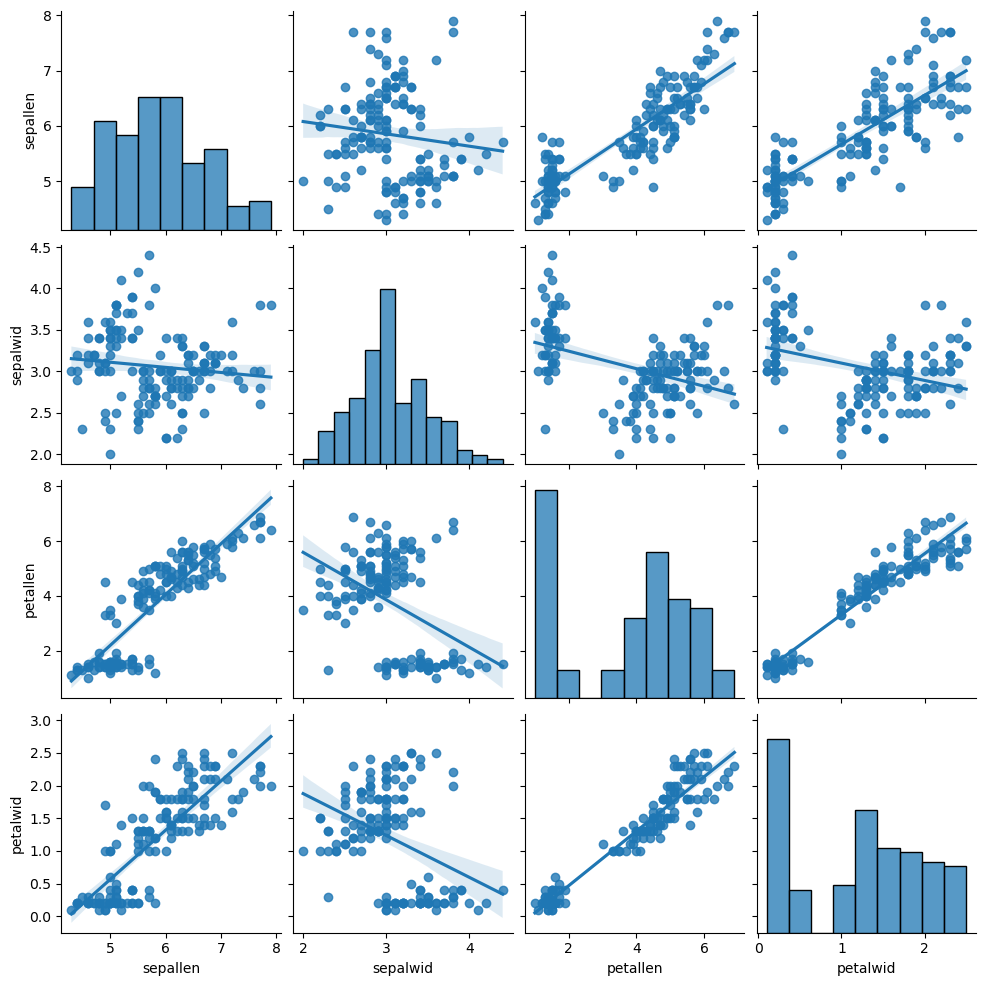

In [5]:
sns.pairplot(data=X, kind='reg', diag_kind='auto')
None

Матричный график рассеяния позволяет увидеть наличие как минимум двух кластеров как из диаграмм рассеяния, так и из гистограмм, где можно пронаблюдать наличие двух вершин. Более ничего по условию задачи нам про выборку неизвестно.

Таким образом, можем предварительно сделать вывод, что алгоритмы кластерного анализа смогут четко выделить минимум 2 кластера в нашей выборке.

## Применение алгоритмов кластеризации в задаче обучения с неклассифицированной выборкой

### Алгоритм К средних

Алгоритм в качестве гиперпараметра принимает число кластеров. Однако на данном этапе нам неизвестно, сколько кластеров в нашей выборке. Поэтому мы возьмем это число из диапазона $[2,10]$ и посмотрим, при каком значении алгоритм работает лучше всего. Оценивать работу алгоритма будем с помощью метрики индекс Калински – Гарабаш. То количестве кластеров, при котором значение этой метрики выше всего, и выберем в качестве гиперпараметра.

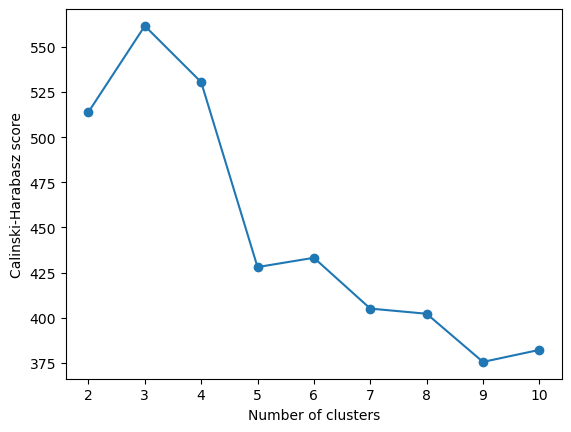

In [198]:
score = []

for i in range(2,11):
    kmeans = KMeans(n_clusters=i, n_init='auto', random_state=41)
    kmeans.fit(X)
    score.append(calinski_harabasz_score(X, kmeans.labels_))

plt.plot(range(2,11), score, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Calinski-Harabasz score')
plt.show()

Получаем наилучший результат при числе кластеров равном 3. Соответственно теперь мы можем считать, что такой выбор числа кластеров вероятно является оптимальным. Подкрепим этот результат, воспользовавшись другой метрикой. Воспользуемя IS-индексом, или индексом силуэта, --- еще одной метрикой для оценки качества кластеризации.

For n_clusters = 2 The average silhouette_score is : 0.6810461692117462
For n_clusters = 3 The average silhouette_score is : 0.5528190123564093
For n_clusters = 4 The average silhouette_score is : 0.49745518901737484
For n_clusters = 5 The average silhouette_score is : 0.43085073194986867


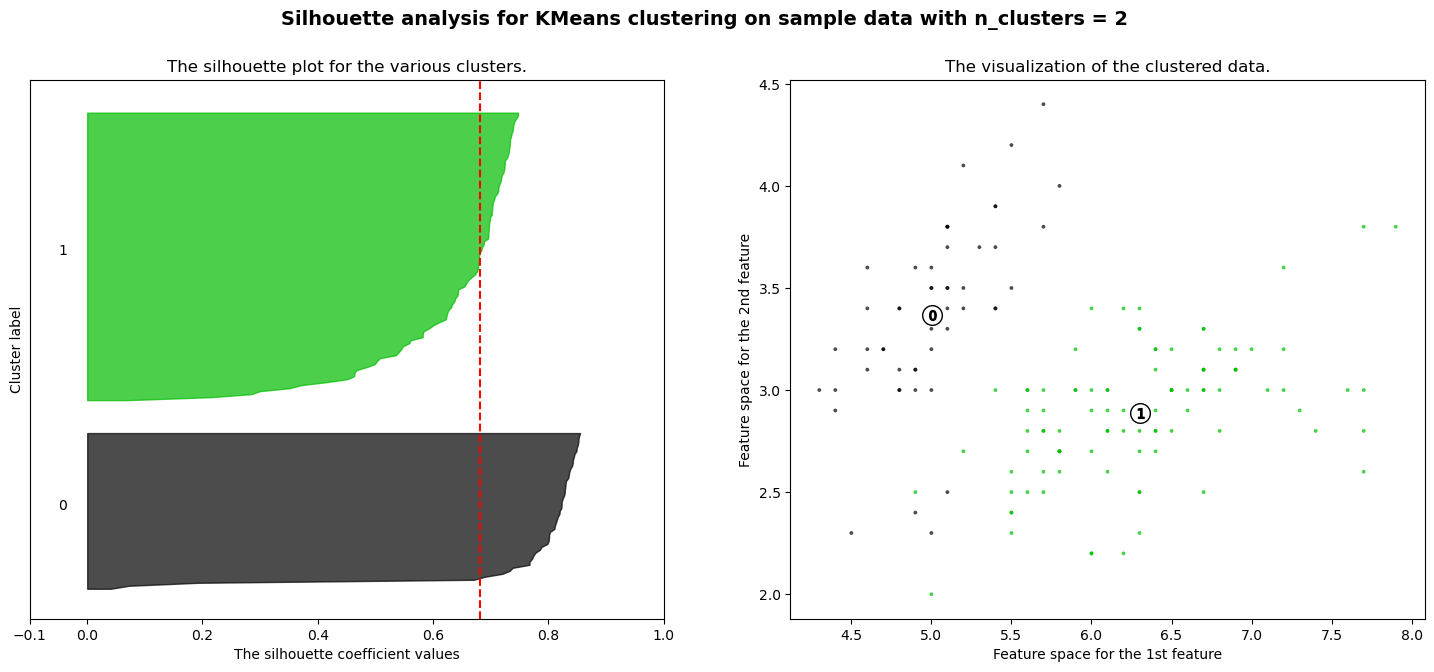

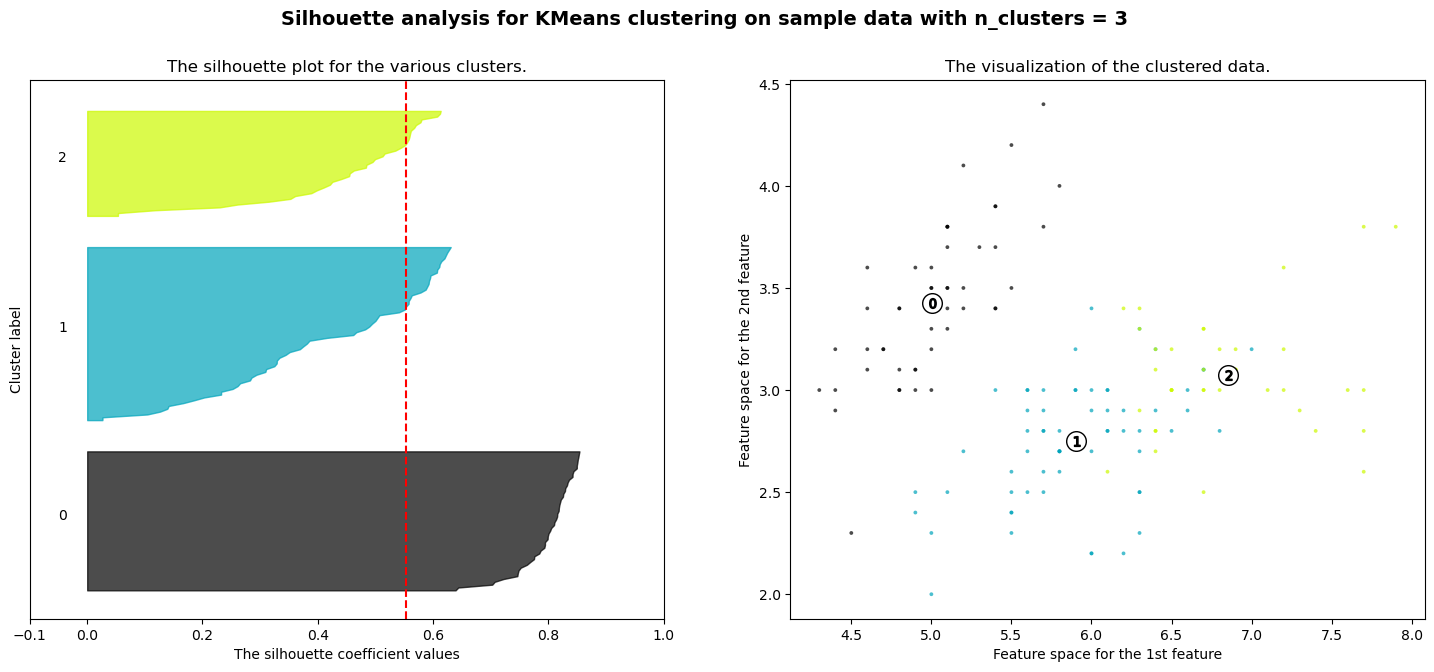

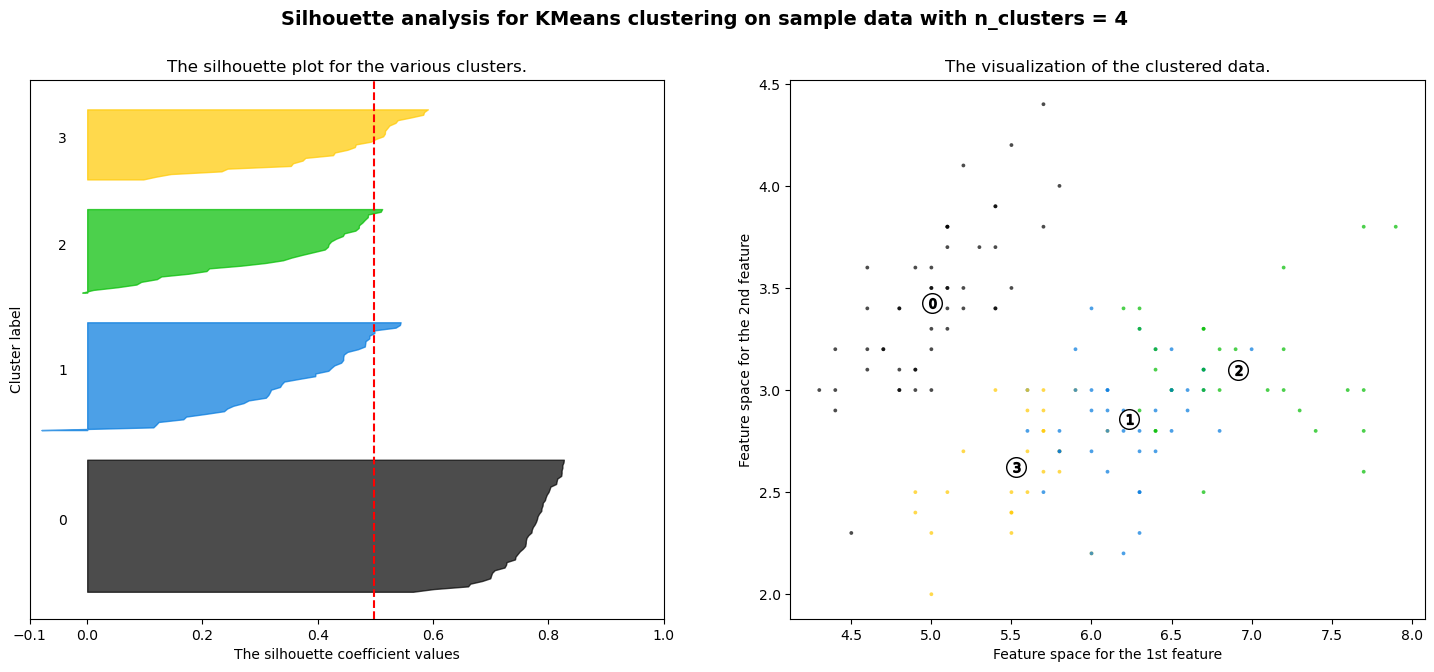

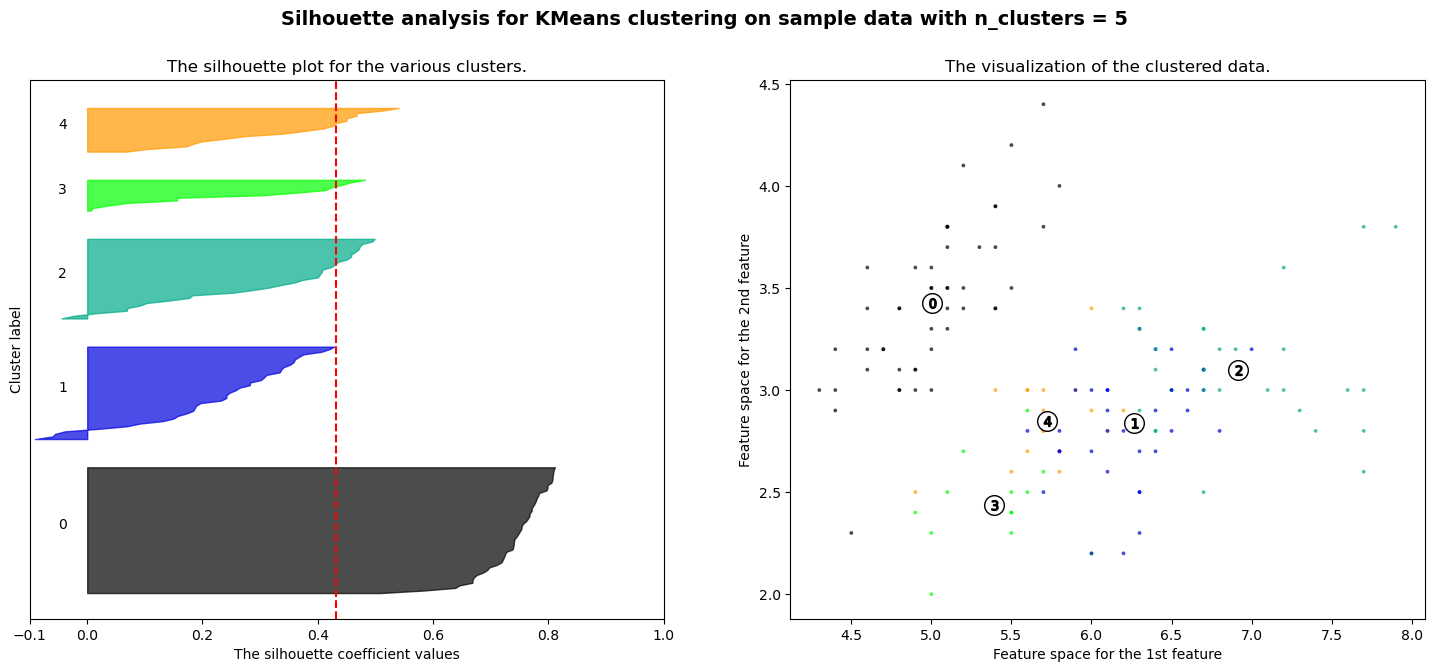

In [199]:
# Reference : https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html#sphx-glr-auto-examples-cluster-plot-kmeans-silhouette-analysis-py
#
#
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import numpy as np

from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs
from sklearn.metrics import silhouette_samples, silhouette_score

range_n_clusters = [2, 3, 4, 5]

for n_clusters in range_n_clusters:
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    ax1.set_xlim([-0.1, 1])
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    clusterer = KMeans(n_clusters=n_clusters, n_init="auto", random_state=41)
    cluster_labels = clusterer.fit_predict(X)

    silhouette_avg = silhouette_score(X, cluster_labels)
    print(
        "For n_clusters =",
        n_clusters,
        "The average silhouette_score is :",
        silhouette_avg,
    )

    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )

        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        y_lower = y_upper + 10

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(
        X.iloc[:, 0], X.iloc[:, 1], marker=".", s=30, lw=0, alpha=0.7, c=colors, edgecolor="k"
    )

    centers = clusterer.cluster_centers_
    ax2.scatter(
        centers[:, 0],
        centers[:, 1],
        marker="o",
        c="white",
        alpha=1,
        s=200,
        edgecolor="k",
    )

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker="$%d$" % i, alpha=1, s=50, edgecolor="k")

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(
        "Silhouette analysis for KMeans clustering on sample data with n_clusters = %d"
        % n_clusters,
        fontsize=14,
        fontweight="bold",
    )

plt.show()

Заметим, что в случаях 2 и 3 кластеров коэффициенты силуэта $>0.6$ для всех кластеров, поэтому оба этих случая являются возможными. Однако наши предыдущие исследования всё же свидетельствуют в пользу случая трех кластеров.

Посмотрим по диаграммам рассеяния, где находятся центры найденных кластеров.

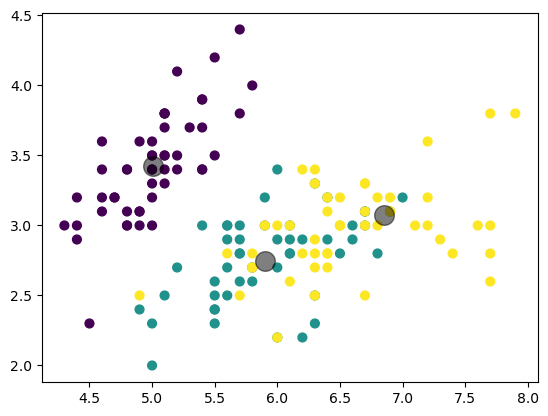

In [200]:
plt.scatter(X.iloc[:, 0], X.iloc[:, 1], c=y, s=40, cmap='viridis')

centers = clf.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5);

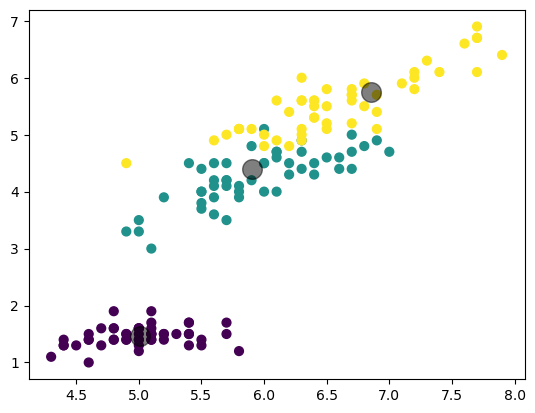

In [201]:
plt.scatter(X.iloc[:, 0], X.iloc[:, 2], c=y, s=40, cmap='viridis')

centers = clf.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 2], c='black', s=200, alpha=0.5);

Заметим, что алгоритм смог вполне хорошо определить центры кластеров. Однако такое представление является не самым удобным, поэтому построим график центров кластеров, т.к. имеем многомерные данные.

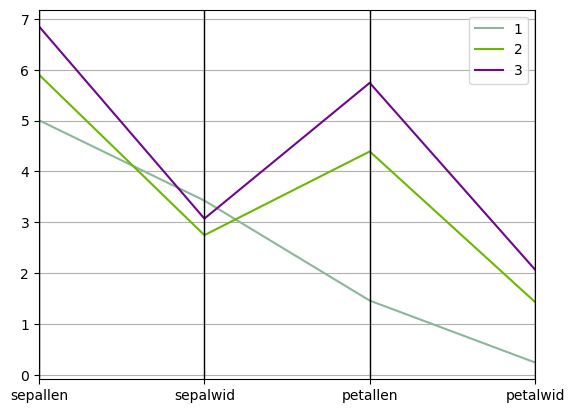

In [202]:
centers = pd.DataFrame(centers, columns=['sepallen', 'sepalwid', 'petallen', 'petalwid'])
centers['label'] = pd.Series([1, 2, 3])
pd.plotting.parallel_coordinates(centers, 'label')
None

Из построенного графика мы можем заметить, что по переменной SEPALWID один из кластеров модель не очень смогла различить. Этот результат вполне ожидаем, так как из построенных ранее диаграмм рассеяния мы уже могли заметить, что по переменной SEPALWID кластеры плохо разделимы.

Рассчитаем показатель accuracy, который будет отображать точность наших предсказаний, по формуле
$$accuracy = \dfrac{1}{n} \sum\limits_{i=1}^n [y^{(i)} =y_{pred}^{(i)}].$$

In [210]:
kmeans = KMeans(n_clusters=3, n_init='auto', random_state=41)
kmeans.fit(X)
sum(kmeans.labels_==y) / y.size

0.8933333333333333

$accuracy\approx 0.9$ --- это достаточно хороший результат для алгоритма. То есть примерно $90%$ меток класса алгоритм предсказал верно.

Проведем также дисперсионный анализ переменных по кластерам.

In [161]:
df = pd.concat([X, pd.DataFrame(y_pred, columns=['label'])],axis=1)
formula = 'label ~ sepallen + sepalwid + petalwid + petallen'
model = ols(formula, data=df).fit()

anova_table = sm.stats.anova_lm(model, typ=2)
anova_table

,sum_sq,df,F,PR(>F)
sepallen,0.240289,1.0,4.191579,0.042431
sepalwid,0.002235,1.0,0.038984,0.843758
petalwid,0.544087,1.0,9.491022,0.002471
petallen,0.740636,1.0,12.919602,0.000445
Residual,8.312347,145.0,NaN,NaN


Заметим, что у переменной SEPALWID уровень значимости больше $0.05$, поэтому гипотеза о межгрупповом равенстве средних не отклоняется. То есть эта переменная не является статистически значимой при проведении кластерного анализа. Причем в этом мы уже убедились ранее дважды, когда выяснили, что по этой переменной наши кластеры плохо различимы.

Таким образом, модель К-средних смогла верно и достаточно неплохо предсказать число кластеров для данной выборки. Показатель accuracy_score дал нам понять, что в почти 90% случаев мы смогли верно предсказать метку класса для рассматриваемого объекта. Также мы выяснили, что переменная SEPALWID оказалась не информативной при проведении кластерного анализа.

### Иерархический кластерный анализ

Аналогично методу К средних, попытаемся определить количество кластеров, перебрав значения из промежутка $[2,10]$ и оценив по СН-метрике.

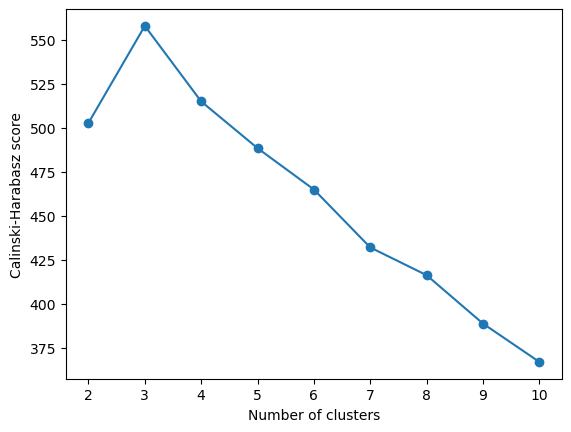

In [205]:
score = []

for i in range(2,11):
    clf = AgglomerativeClustering(n_clusters=i, metric='euclidean')
    clf.fit(X)
    score.append(calinski_harabasz_score(X, clf.labels_))

plt.plot(range(2,11), score, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Calinski-Harabasz score')
plt.show()

Заметно, что значение CH-метрики больше всего при 3 кластерах, что совпадает с результатами предыдущего исследования. Далее для подкрепления этого результата воспользуемся дендрограммой и графиком расстояний между объединяемыми кластерами.

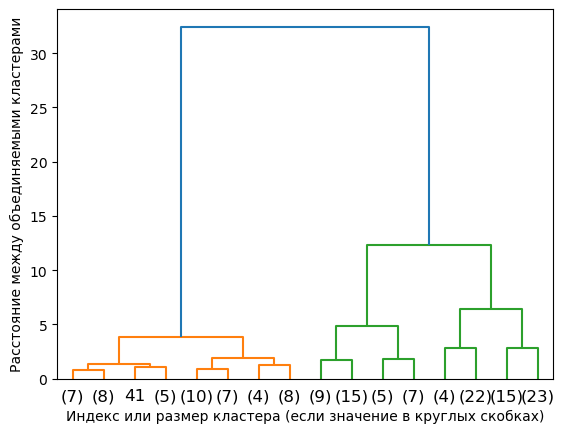

In [206]:
# Reference : https://scikit-learn.org/stable/auto_examples/cluster/plot_agglomerative_dendrogram.html#sphx-glr-auto-examples-cluster-plot-agglomerative-dendrogram-py
#
#
def plot_dendrogram(model, **kwargs):
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)
    dendrogram(linkage_matrix, **kwargs)


model = AgglomerativeClustering(distance_threshold=0, n_clusters=None)

model = model.fit(X)
plot_dendrogram(model, truncate_mode="level", p=3)
plt.xlabel("Индекс или размер кластера (если значение в круглых скобках)")
plt.ylabel('Расстояние между объединяемыми кластерами')
plt.show()

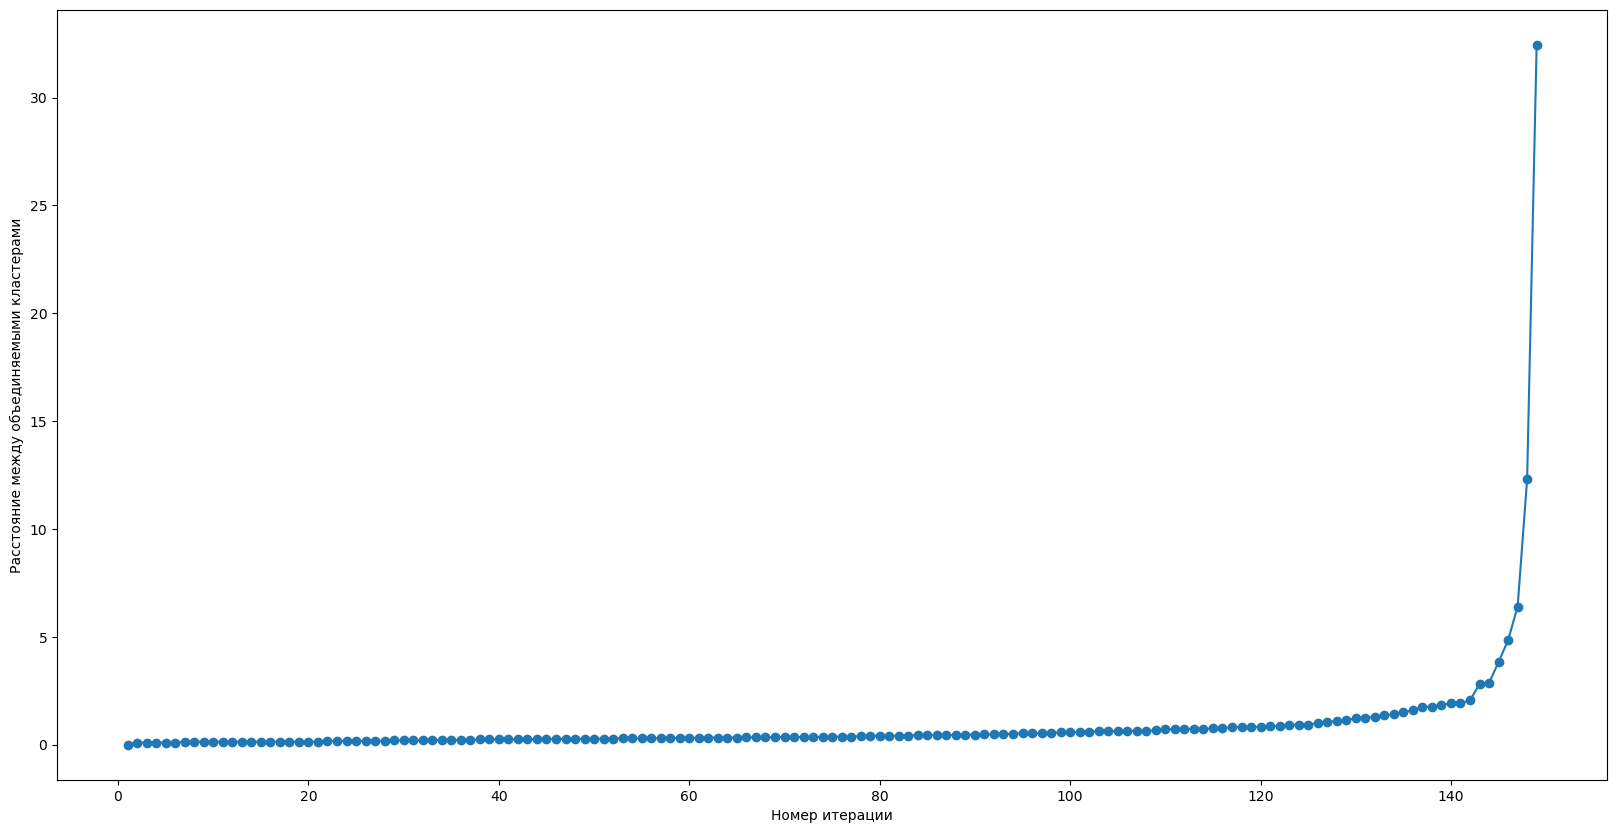

In [207]:
clf = AgglomerativeClustering(n_clusters=3, compute_distances=True)
plt.figure(figsize=(20, 10))
plt.plot(range(1, len(X)), clf.fit(X).distances_, marker='o')
plt.xlabel('Номер итерации')
plt.ylabel('Расстояние между объединяемыми кластерами')
plt.show()

Из рисунков можно предположить, что возможное число кластеров в рассматриваемом случае равно 3, так как второй график резко уходит вверх примерно на значениях 6-10, которые соответствуют трем кластерам в первом графике.

Таким образом, по совокупности всех признаков мы можем принять предположение о том, что в нашей выборке действительно выделяются 3 кластера.

Для оценки того, насколько хорошо модель справилась с предсказанием метки класса, рассчитаем покахатель accuracy.

In [213]:
clf = AgglomerativeClustering(n_clusters=3)
clf.fit(X)
sum(clf.labels_==y) / y.size

0.23333333333333334

Относительно предыдущего алгоритма иерархический кластерный анализ справился значительно хуже с определением меток класса у объектов. Всего $24%$ меток класса алгоритм смог правильно предсказать.

Проведем в данном случае дисперсионный анализ.

In [208]:
df = pd.concat([X, pd.DataFrame(clf.labels_, columns=['label'])],axis=1)
formula = 'label ~ sepallen + sepalwid + petalwid + petallen'
model = ols(formula, data=df).fit()

anova_table = sm.stats.anova_lm(model, typ=2)
anova_table

,sum_sq,df,F,PR(>F)
sepallen,3.485118,1.0,7.939945,0.005511
sepalwid,5.951978,1.0,13.560053,0.000325
petalwid,2.812623,1.0,6.407839,0.012428
petallen,1.994937,1.0,4.544951,0.034701
Residual,63.645532,145.0,NaN,NaN


Заметим, что теперь мы получили, что у каждой переменной уровень значимости ниже $0.05$, соответственно мы не принимаем гипотез о равенстве межгрупповых средних, то есть все признаки в случае ИАК оказались информативными для модели.

# Вывод

Все рассмотренные выше алгоритмы смогли различить 3 кластера в рассматриваемой выборке. Однако алгоритм К-средних смог с более высокой, чем ИАК, точностью предсказать метки классов для объектов. Таким образом, мы можем считать, что задача кластеризации данных без обучающей выборки с использованием рассмотренных алгоритмов решена достаточно неплохо. На пратике истинные метки классов могут быть неизвестны, так что может и не быть возможности рассчитать accuracy_score для оценки качества классификации. Поэтому в этом случае стоит применять оба алгоритма и стараться ориентироваться как минимум на те результаты, которые совпадают у двух алгоритмов. При несовпадении необходимо проводить дополнительные исследования или вовсе дополнительные наблюдения для получения большего количества данных.